# Brief description of the problem and data

## Challenge Problem Overview

The challenge revolves around creating an algorithm capable of identifying metastatic cancer from small image patches derived from larger digital pathology scans. This problem set framework is from a Kaggle Competition and it leverages the PatchCamelyon (PCam) benchmark dataset. The primary objective is binary image classification: determing whether a given image patch contains at least one pixel of tumor tissue.

## Data Description

* **Dataset Origin**: The dataset is a slightly modified version of the PCam benchmark, specifically curated to remove duplicate images which were present in the original dataset due to probabilistic sampling.
* **Clinical Relevance**: The task mirrors the clinical challenge of metastasis detection, simplifying it into a binary classification akin to well-known datasets like CIFAR-10 and MNIST. It is designed to be accessible for training on a single GPU within a couple of hours, making it appealing for a broad spectrum of machine learning research including active learning, model uncertainty, and explainability. 
* **Dataset Structure**: 
   * **Size and Composition**: The dataset consist of a large number of small pathology images. Each file is named with an image ID. 
   * **Labeling**: The ```train_labels.csv``` file provides ground truth for the images in the train folder, indicating whether the center 32x32px region of a patch contains tumor tissue. The presence of tumor tissue in the outer region of the patch does not influence the label.
   * **Uniqueness**: All images in this version of the dataset are unique, addressing the issue of duplicates found in the original PCam dataset.
   * **Dataset Splits**: The dataset maintains the same data splits as the original PCam benchmark.
* **Evaluation Criteria**: Submissions are evaluated based on the area under the ROC curve between the predicted probability and the observed target for the test set images.

## Additional Information
* **Licensing**: The data is provided under the CC0 License, in line with the Camelyon16 license.
* **Acknowledgements**: The dataset is provided by Bas Veeling, with additional input from other contributors. The competition is hosted on Kaggle for practice and community engagement. 
* **Timeline**: The competition concluded on March 30, 2019.
* **Prizes**: The top five most popular Kernels, determined by the number of upvotes at the deadline, received Kaggle Swag.

The data and challenge are designed to be both approachable for beginners and rich enough for more in-depth analysis, making it a valuable resource for machine learning practitioners interested in medical image analysis.

#### Reading in Libaries

In [10]:
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from skimage import exposure
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import imgaug as ia
import imgaug.augmenters as iaa
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil

#### Initializing Functions

In [19]:
def verify_images(image_folder): 
    corrupt_files = []
    for img_id in tqdm(labels_df['id']): 
        try: 
            img_path = os.path.join(image_folder, img_id + '.tif')
            img = Image.open(img_path)
            ## Verify if it's an image
            img.verify()
        except (IOError, SyntaxError) as e: 
            corrupt_files.append(img_id)
    return corrupt_files

def plot_sample_images(df, image_folder, n = 5): 
    fig, axes = plt.subplots(1, n * 2, figsize = (20, 4))
    for i, label in enumerate([0, 1]): 
        sample_ids = df[df['label'] == label].sample(n)['id'].values
        for j, img_id in enumerate(sample_ids): 
            img_path = os.path.join(image_folder, img_id + '.tif')
            img = Image.open(img_path)
            axes[i * n + j].imshow(img)
            axes[i * n + j].axis('off')
            axes[i * n + j].set_title(f"Label: {label}")
    plt.tight_layout()
    plt.show()
    
def plot_pixel_intensity_distribution(sample_ids, image_folder): 
    fig, ax = plt.subplots()
    for img_id in sample_ids: 
        img_path = os.path.join(image_folder, img_id + '.tif')
        img = Image.open(img_path)
        pixels = np.array(img).flatten()
        ax.hist(pixels, bins = 256, alpha = 0.5, label = img_id)
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')
    plt.legend()
    plt.show()
    
# Function to apply CLAHE to an image
def apply_clahe(image_path, output_folder): 
    try: 
        # Read the image in grayscale mode
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Create a CLAHE object, with optional arguments
        clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
        clahe_img = clahe.apply(image)
        
        # Normalize the image to the range [0, 1]
        clahe_img_normalized = cv2.normalize(clahe_img, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        
        # Construct the output path and save the processed image
        file_name = os.path.basename(image_path)
        output_path = os.path.join(output_folder, file_name)
        ## Convert back to [0,255] range for saving
        cv2.imwrite(output_path, clahe_img_normalized * 255)
    except Exception as e: 
        print(f"Error processing {image_path}: {e}")
        
def convert_image(input_dir, output_dir, filename): 
    try: 
        image_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        
        with Image.open(image_path) as img: 
            # Convert the image to 8-bit per channel
            img = img.point(lambda i: i * (1. / 256)).convert('L')
            
            # Save the image
            img.save(output_path)
    except Exception as e: 
        print(f"Error converting image {filename}: {e}")

def build_model(learning_rate): 
    model = Sequential()
    # Add model layers
    model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (image_height, image_width, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # Flatten and add a dense layer
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model
    

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

## Data Inspection and Cleaning
1. **Inspect the Distribution of Labels**: The first step is to check the balance between positive (cancerous) and negative (non-cancerous) samples.

In [3]:
# Load labels
labels_df = pd.read_csv('/Users/calebwhite/Downloads/histopathologic-cancer-detection/train_labels.csv')

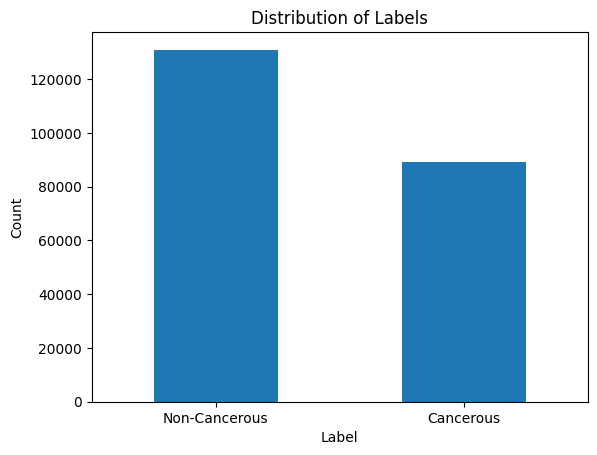

In [4]:
# Plot histogram
labels_df['label'].value_counts().plot(kind = 'bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks = [0, 1], labels = ['Non-Cancerous', 'Cancerous'], rotation = 0)
plt.show()

Bason on the chart, it seems that the dataset has a larger number of non-cancerous samples compared to cancerous ones, which suggests a class imbalance. This is an import aspect to consider during model training as it could lead to bias towards the majority class.

2. **Data Cleaning**: Since the dataset has been preprocessed to remove duplicates, the main cleaning step would involve checking for corrupt images or those that don't open. This can be achieved by attempting to load each image and removing entries for any that fail to load.

In [4]:
corrupt_files = verify_images('/Users/calebwhite/Downloads/histopathologic-cancer-detection/train/')

100%|█████████████████████████████████| 220025/220025 [01:09<00:00, 3177.61it/s]


In [5]:
# Remove corrupt files from the dataframe
labels_df = labels_df[~labels_df['id'].isin(corrupt_files)]

Now that we have verified that none of the images are corrupt, we can proceed with further data analysis. 

## Visualization for EDA

1. **Visualize Sample Images**: To get a sense of the data, visualize some sample images from both classes.

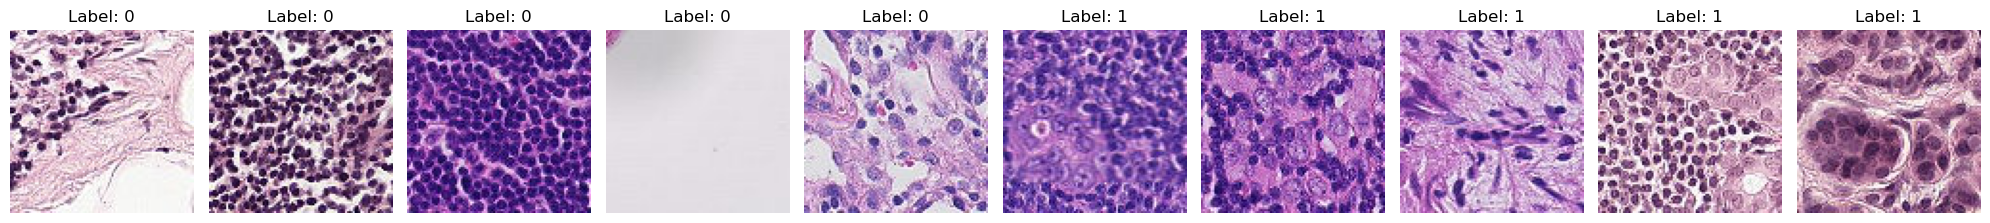

In [14]:
plot_sample_images(labels_df, '/Users/calebwhite/Downloads/histopathologic-cancer-detection/train/')

Unfornuately, I'm not a histopathologist myself, so I'll have to assume that the labeling of these are correct. The labeling of '1' shows us that the histological features indicate cancer is present. 

2. **Inspect Image Pixel Intensity Distributions**: Understanding the distribution of pixel intensities can help in identifying any preprocessing steps.

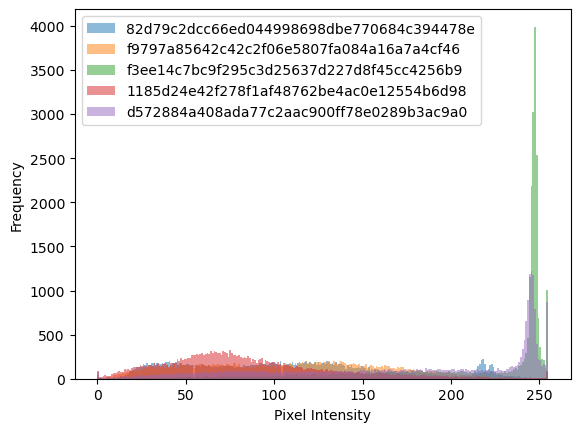

In [16]:
plot_pixel_intensity_distribution(labels_df.sample(5)['id'].values, '/Users/calebwhite/Downloads/histopathologic-cancer-detection/train/')

The histograms suggest variation in the distribution of pixels intensities across images, which can be due to differences in staining, lighting, or tissue types. Such variations highlight the need for normalization/standardization of images before feeding them into a machine learning model to ensure that the model isn't biased by variations in brightness or contrast. The spikes at the extreme ends of some histograms (such as the green one on the right end) could indicate outliers or artifacts that might need to be addressed.

## Plan of Analysis Based on EDA

1. **Preprocessing**: Apply histogram equalization and adaptive histogram equalization (CLAHE) for contrast enhancement. Normalize the images so that the pixel intensity distribution is similar across the dataset.

In [6]:
# Path to the directory containing the images
input_folder = '/Users/calebwhite/Downloads/histopathologic-cancer-detection/train/'
output_folder = '/Users/calebwhite/Downloads/histopathologic-cancer-detection/train_normalized/'

In [7]:
# Create output folder
os.makedirs(output_folder, exist_ok = True)

In [8]:
# Get a list of image file paths
image_paths = [os.path.join(input_folder, filename) for filename in os.listdir(input_folder) if filename.endswith('.tif')]

In [9]:
# Process images in parallel using threads instead of processes
## Number of threads to use. Running on Macbook Air M1 with 16GB memory
num_threads = os.cpu_count()
with ThreadPoolExecutor(max_workers = num_threads) as executor: 
    list(tqdm(executor.map(apply_clahe, image_paths, [output_folder] * len(image_paths)), total = len(image_paths)))

100%|█████████████████████████████████| 220025/220025 [00:49<00:00, 4479.28it/s]


We have now normalized the images, time to see the new results!

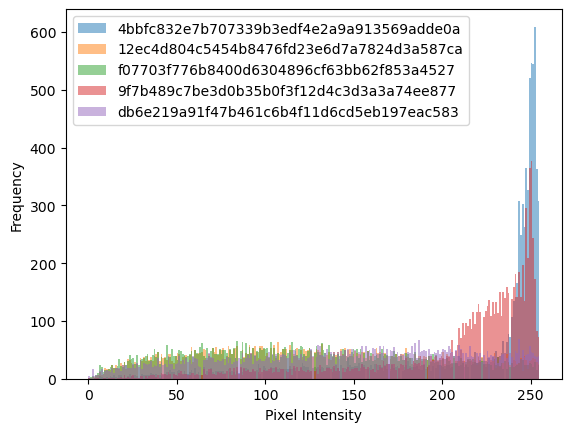

In [30]:
plot_pixel_intensity_distribution(labels_df.sample(5)['id'].values, output_folder)

As before, the colored histogram represents the distrubtion within a single image. The pixel intensities are distributed across the entire range, which is what we were expecting after applying histogram equalization. The peaks suggest where the most common pixel values lie. Since we expect normalized images to have pixel values within a specific range (usually [0, 255] for image data), the distribution reaching the edges of the x-axis indicates that normalization was successful. It seems the operations using CLAHE have generally led to more even distribution of pixel intensisties, which should improve visibility of features within the images for subsequent analysis and machine learning tasks.

2. **Augmentation**: Considering the balance between classes, use image augmentation techniques like rotation, flipping, and zooming to enhance the dataset, especially for the underrepresented class.

I am going to create a validation set for the training set to monitor the model's performance on unseen data during training, which will help in tuning hyperparameters and avoid overfitting.

In [11]:
# Set your directories to here
validation_dir = '/Users/calebwhite/Downloads/histopathologic-cancer-detection/validation_normalized/'

# Creating the validation directory
os.makedirs(validation_dir, exist_ok = True)

In [12]:
# Get a list of all files in the training directory
all_files = os.listdir(output_folder)
all_files = [f for f in all_files if f.endswith('.tif')]

# Split files into training and validation sets
train_files, validation_files = train_test_split(all_files, test_size = 0.2, random_state = 42)

In [13]:
# Move the selected files to the validation directory
for file_name in validation_files: 
    shutil.move(os.path.join(output_folder, file_name), os.path.join(validation_dir, file_name))

print(f"Moved {len(validation_files)} files to the validation directory.")

Moved 44005 files to the validation directory.


In [14]:
# Create an instance of ImageDataGenerator with desired augmentations
data_gen_args = dict(
    ## Random rotations from 0 to 90 degrees
    rotation_range = 90, 
    ## Random horizontal shifts
    width_shift_range = 0.1,
    ## Random vertical shifts
    height_shift_range = 0.1, 
    ## Shearing
    shear_range = 0.1, 
    ## Random Zoom
    zoom_range = 0.2, 
    ## Horizontal Flips
    horizontal_flip = True, 
    ## Vertical Flips
    vertical_flip = True, 
    ## Strategy to fill newly created pixels
    fill_mode = 'nearest'
)

In [15]:
# Prepare the data generator for training
train_datagen = ImageDataGenerator(**data_gen_args)

In [16]:
labels_df['label'] = labels_df['label'].astype(str)
labels_df['id'] = labels_df['id'].apply(lambda x: f"{x}.tif")
labels_df['is_validation'] = labels_df['id'].apply(lambda x: x in validation_files)
train_labels_df = labels_df[~labels_df['is_validation']].drop(columns = ['is_validation'])
validation_labels_df = labels_df[labels_df['is_validation']].drop(columns = ['is_validation'])

In [17]:
image_height = 96
image_width = 96
batch_size = 32

# Normalized training data in 'output_folder' with subdirectories for each class
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_labels_df,
    directory = output_folder,
    x_col = 'id', 
    y_col = 'label',
    target_size = (image_height, image_width), 
    batch_size = batch_size, 
    ## 'categorical' for more than two classes
    class_mode = 'binary', 
    color_mode = 'grayscale'
)

Found 176020 validated image filenames belonging to 2 classes.


In [18]:
# Only rescaling for validation
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_labels_df,
    directory = validation_dir,
    x_col = 'id', 
    y_col = 'label',
    target_size = (image_height, image_width), 
    batch_size = batch_size, 
    ## 'categorical' for more than two classes
    class_mode = 'binary', 
    color_mode = 'grayscale'
)

Found 44005 validated image filenames belonging to 2 classes.


Great! We have now found and recognized all 220,025 image files and associated them with two classes for binary classification. We have split them into 176,020 training data records and 44,005 validation data records. Our dataset is now ready to be used for training the machine learning model. 

3. **Model Selection**: Given the binary nature of the task, start with a simple CNN architecture and progressively increase complexity based on performance.
4. **Evaluation**: Focus on metrics like AUC-ROC in addition to accuracy, given the clinical significance of false negatives and false positives in cancer detection.

# DModel Architecture

## Model Architecture

For the task of identifying metastatic cancer in histopathological images, I propose starting with a relatively simple CNN architecture and progressing to more complex ones if needed. Below is a potential architecture: 

Simple CNN Architecture (Baseline)

The baseline model has two convolutional layers: 

* **Convolutional Layer 1**: 32 filters of size 3x3, ReLU activation
* **Max Pooling Layer 1**: 2x2 pool size
* **Convolutional Layer 2**: 64 filters of size 3x3, ReLU activation
* **Max Pooling Layer 2**: 2x2 pool size
* **Flattening Layer**: Flattens the input
* **Dense Layer 1**: 64 neuons, ReLU activation
* **Dropout Layer**: Rate 0.5 to prevent overfitting
* **Output Layer**: 1 neuron with sigmoid activation for binary classification

This model is chosen as the starting point because it is not computationally intensive and can be trained relatively quickly. It provides a good baseline to understand how well simple features can separate the two classes.

In [49]:
# Define the model
model = Sequential()

In [50]:
# First convolutional layer
model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (image_height, image_width, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

In [51]:
# Second convolutional layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

In [52]:
# Flatten and add a dense layer
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

In [53]:
# Output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [54]:
# Compile the model
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [55]:
# Train the model using the train_generator
history = model.fit(
    train_generator, 
    ## Ensures that each sample is seen once per epoch
    steps_per_epoch = train_generator.samples // train_generator.batch_size, 
    ## Number of epochs to train for, using Macbook Air M1, 16GB Memory
    epochs = 10, 
    ## Replace with your validation generator if you have one
    validation_data = validation_generator, 
    ## Ensures each validation sample is seen once per epoch
    validation_steps = validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10


2024-03-20 18:58:59.131090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5500/5500 [==============================] - ETA: 0s - loss: 0.8128 - accuracy: 0.6817

2024-03-20 19:09:32.070374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5500/5500 [==============================] - 682s 124ms/step - loss: 0.8128 - accuracy: 0.6817 - val_loss: 0.6910 - val_accuracy: 0.5868
Epoch 2/10
5500/5500 [==============================] - 677s 123ms/step - loss: 0.5166 - accuracy: 0.7524 - val_loss: 8.1248 - val_accuracy: 0.5915
Epoch 3/10
5500/5500 [==============================] - 1047s 190ms/step - loss: 0.4862 - accuracy: 0.7776 - val_loss: 6.0506 - val_accuracy: 0.5914
Epoch 4/10
5500/5500 [==============================] - 666s 121ms/step - loss: 0.4738 - accuracy: 0.7859 - val_loss: 3.3247 - val_accuracy: 0.5915
Epoch 5/10
5500/5500 [==============================] - 1119s 204ms/step - loss: 0.4709 - accuracy: 0.7878 - val_loss: 6.7454 - val_accuracy: 0.5914
Epoch 6/10
5500/5500 [==============================] - 731s 133ms/step - loss: 0.4656 - accuracy: 0.7904 - val_loss: 10.6627 - val_accuracy: 0.5914
Epoch 7/10
5500/5500 [==============================] - 665s 121ms/step - loss: 0.4643 - accuracy: 0.7911 - val_loss: 29

In [56]:
# Save the model
model.save('/Users/calebwhite/Downloads/histopathologic-cancer-detection/model/model.h5')

In [57]:
# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        320       
                                                                 
 activation_8 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 activation_9 (Activation)   (None, 46, 46, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                  

It appears that the model is well-suited for processing histopathological images to identify features indicative of metastatic cancer. Here's a breakdown of the architecture and some insights: 

## Model Architecture Overview
* **Input Layer**: Not explicitly defined in Keras model as it infers input shape from the first layer.
* **First Convolutional Layer (```conv2d_5```)**: Consists of 32 filters of size 3x3.
* **Activation Layer (```activation_8```)**: Applies the ReLU activation function, introducing non-linearity and helping with the vanishing gradient problem.
* **Max Pooling Layer (```max_pooling2d_4```)**: Reduces the spatial dimensions of the input volume by half, which decreases the number of parameters and computation in the network, and helps prevent overfitting.
* **Second Convolutional Layer (```conv2d_6```)**: Increases the filter count to 64, allowing the network to capture more complex features.
* **Flatten Layer (```flatten_2```)**: Flattens the 3D output of the last convolutional layer into a 1D vector, enabling it to be fed into the subsequent dense layers.
* **Dense Layer (```dense_4```)**: A fully connected layer with 64 neurons.
* **Droput Layer (```droupout_2```)**: Applies a dropout rate of 0.5, randomly setting a fraction of input units to 0 at each update during training, which helps in reducing overfitting.
* **Output Layer (```dense_5```)**: Consists of a single neuron with a sigmoid activation function, used for binary classification to output a probability indicating the presence or absence of metastatic cancer.

## Total Parameters
* The model has a total of 2,185,729 trainable parameters, which suggests it has a significant capacity to learn from the data. The relatively large number of parameters also means the model might require more data to train effectively without overfitting.

## Considerations and Potential Adjustments
* **Capacity and Complexity**: If this was a real-life scenario and we were given this amount of data, we would need to adjust the model's capacity either by adding more layers or convolutional filters, or by reducing them if we're facing overfitting.
* **Data Augmentation**: Given the model's capacity, employing an even more robust data augmentation strategy than what we have already employed would be crucial to prevent overfitting and to improve the model's ability to generalize to unseen data.

Our architecture provides a solid foundation for our task. We should monitor the training and validation performance closely, and be prepared to iterate on the model design based on the results we observe.

Given the CNN architecture, there are several ways we can conduct hyperparameter tuning. 

## Hyperparameter Tuning
* **Learning Rate**: Start with a learning rate of 0.001 and experiment with higher or lower rates to find the optimal balance between training speed and convergence stability.
* **Batch Size**: Test different batch sizes, such as 32, 64, or 128.
* **Optimizer**: While we are going to use Adam, we may also consider trying SGD with momentum or RMSprop to see if they offer any performance benefits.
* **Dropout Rate**: The current architecture uses a dropout rate of 0.5.

Let's experiment with different learning rates and batch sizes.

In [21]:
learning_rates = [0.001, 0.0001, 0.01]
batch_sizes = [32, 64, 128]

results = []

for lr in learning_rates: 
    for bs in batch_sizes: 
        # Build and train the model
        model = build_model(learning_rate = lr)
        history = model.fit(
            train_generator, 
            validation_data = validation_generator, 
            epochs = 10, 
            batch_size = bs, 
            ## Set to 0 for no logging, 1 for progress bar, 2 for one line per epoch
            verbose = 2
        )

        # Store the final validation accuracy and loss
        val_accuracy = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1]

        # Store this experiment's result
        results.append({
            'learning_rate': lr, 
            'batch_size': bs, 
            'validation_accuracy': val_accuracy, 
            'validation_loss': val_loss
        })

Epoch 1/10


2024-03-21 18:07:46.806792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-21 18:12:45.393507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5501/5501 - 325s - loss: 2.5333 - accuracy: 0.5942 - val_loss: 0.6764 - val_accuracy: 0.5914 - 325s/epoch - 59ms/step
Epoch 2/10
5501/5501 - 350s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6765 - val_accuracy: 0.5914 - 350s/epoch - 64ms/step
Epoch 3/10
5501/5501 - 344s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 344s/epoch - 63ms/step
Epoch 4/10
5501/5501 - 345s - loss: 0.6985 - accuracy: 0.5958 - val_loss: 0.6707 - val_accuracy: 0.5914 - 345s/epoch - 63ms/step
Epoch 5/10
5501/5501 - 367s - loss: 0.6467 - accuracy: 0.5959 - val_loss: 0.6802 - val_accuracy: 0.5914 - 367s/epoch - 67ms/step
Epoch 6/10
5501/5501 - 499s - loss: 0.6450 - accuracy: 0.5958 - val_loss: 0.6662 - val_accuracy: 0.5914 - 499s/epoch - 91ms/step
Epoch 7/10
5501/5501 - 347s - loss: 0.6456 - accuracy: 0.5959 - val_loss: 0.8203 - val_accuracy: 0.5914 - 347s/epoch - 63ms/step
Epoch 8/10
5501/5501 - 2849s - loss: 0.6455 - accuracy: 0.5957 - val_loss: 1.6424 - val_accuracy: 0.5914 - 2

2024-03-21 19:49:13.884130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-21 19:54:54.471180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5501/5501 - 404s - loss: 1.7870 - accuracy: 0.5954 - val_loss: 0.6764 - val_accuracy: 0.5914 - 404s/epoch - 73ms/step
Epoch 2/10
5501/5501 - 1172s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6765 - val_accuracy: 0.5914 - 1172s/epoch - 213ms/step
Epoch 3/10
5501/5501 - 694s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6767 - val_accuracy: 0.5914 - 694s/epoch - 126ms/step
Epoch 4/10
5501/5501 - 331s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6765 - val_accuracy: 0.5914 - 331s/epoch - 60ms/step
Epoch 5/10
5501/5501 - 346s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 346s/epoch - 63ms/step
Epoch 6/10
5501/5501 - 343s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 343s/epoch - 62ms/step
Epoch 7/10
5501/5501 - 344s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 344s/epoch - 62ms/step
Epoch 8/10
5501/5501 - 342s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 

2024-03-21 21:12:36.885011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-21 21:27:25.362246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5501/5501 - 913s - loss: 1.1781 - accuracy: 0.5952 - val_loss: 0.6763 - val_accuracy: 0.5914 - 913s/epoch - 166ms/step
Epoch 2/10
5501/5501 - 331s - loss: 0.6809 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 331s/epoch - 60ms/step
Epoch 3/10
5501/5501 - 337s - loss: 0.6904 - accuracy: 0.5959 - val_loss: 0.6770 - val_accuracy: 0.5914 - 337s/epoch - 61ms/step
Epoch 4/10
5501/5501 - 335s - loss: 0.6562 - accuracy: 0.5959 - val_loss: 0.6778 - val_accuracy: 0.5914 - 335s/epoch - 61ms/step
Epoch 5/10
5501/5501 - 339s - loss: 0.6546 - accuracy: 0.5958 - val_loss: 0.6775 - val_accuracy: 0.5914 - 339s/epoch - 62ms/step
Epoch 6/10
5501/5501 - 339s - loss: 0.6549 - accuracy: 0.5959 - val_loss: 0.6774 - val_accuracy: 0.5914 - 339s/epoch - 62ms/step
Epoch 7/10
5501/5501 - 342s - loss: 0.6522 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 342s/epoch - 62ms/step
Epoch 8/10
5501/5501 - 345s - loss: 0.6274 - accuracy: 0.5959 - val_loss: 0.6839 - val_accuracy: 0.5914 - 3

2024-03-21 22:35:09.556338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-21 22:40:27.301012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5501/5501 - 1248s - loss: 0.7784 - accuracy: 0.5953 - val_loss: 0.6776 - val_accuracy: 0.5914 - 1248s/epoch - 227ms/step
Epoch 2/10
5501/5501 - 2075s - loss: 0.6752 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 2075s/epoch - 377ms/step
Epoch 3/10
5501/5501 - 322s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 322s/epoch - 59ms/step
Epoch 4/10
5501/5501 - 332s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 332s/epoch - 60ms/step
Epoch 5/10
5501/5501 - 337s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 337s/epoch - 61ms/step
Epoch 6/10
5501/5501 - 336s - loss: 0.6845 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 336s/epoch - 61ms/step
Epoch 7/10
5501/5501 - 22659s - loss: 0.6814 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 22659s/epoch - 4s/step
Epoch 8/10
5501/5501 - 5513s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.

2024-03-22 07:53:28.115063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 08:00:35.463881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5501/5501 - 452s - loss: 0.8439 - accuracy: 0.5956 - val_loss: 0.6777 - val_accuracy: 0.5914 - 452s/epoch - 82ms/step
Epoch 2/10
5501/5501 - 1374s - loss: 0.6753 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 1374s/epoch - 250ms/step
Epoch 3/10
5501/5501 - 1828s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 1828s/epoch - 332ms/step
Epoch 4/10
5501/5501 - 1308s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 1308s/epoch - 238ms/step
Epoch 5/10
5501/5501 - 353s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 353s/epoch - 64ms/step
Epoch 6/10
5501/5501 - 359s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 359s/epoch - 65ms/step
Epoch 7/10
5501/5501 - 361s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 361s/epoch - 66ms/step
Epoch 8/10
5501/5501 - 347s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.

2024-03-22 10:33:32.844625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 10:43:02.938891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5501/5501 - 595s - loss: 0.8153 - accuracy: 0.5953 - val_loss: 0.6775 - val_accuracy: 0.5914 - 595s/epoch - 108ms/step
Epoch 2/10
5501/5501 - 3673s - loss: 0.6752 - accuracy: 0.5959 - val_loss: 0.6763 - val_accuracy: 0.5914 - 3673s/epoch - 668ms/step
Epoch 3/10
5501/5501 - 1163s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 1163s/epoch - 211ms/step
Epoch 4/10
5501/5501 - 330s - loss: 0.6785 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 330s/epoch - 60ms/step
Epoch 5/10
5501/5501 - 1806s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 1806s/epoch - 328ms/step
Epoch 6/10
5501/5501 - 2652s - loss: 0.6812 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 2652s/epoch - 482ms/step
Epoch 7/10
5501/5501 - 830s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy: 0.5914 - 830s/epoch - 151ms/step
Epoch 8/10
5501/5501 - 2481s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6764 - val_accura

2024-03-22 14:30:43.470296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 14:36:05.697771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5501/5501 - 350s - loss: 5.1247 - accuracy: 0.5946 - val_loss: 2.8851 - val_accuracy: 0.5914 - 350s/epoch - 64ms/step
Epoch 2/10
5501/5501 - 349s - loss: 0.6762 - accuracy: 0.5958 - val_loss: 2.5781 - val_accuracy: 0.5914 - 349s/epoch - 63ms/step
Epoch 3/10
5501/5501 - 360s - loss: 0.6754 - accuracy: 0.5958 - val_loss: 0.6765 - val_accuracy: 0.5914 - 360s/epoch - 65ms/step
Epoch 4/10
5501/5501 - 335s - loss: 0.6749 - accuracy: 0.5959 - val_loss: 0.6763 - val_accuracy: 0.5914 - 335s/epoch - 61ms/step
Epoch 5/10
5501/5501 - 335s - loss: 0.6749 - accuracy: 0.5959 - val_loss: 2.7161 - val_accuracy: 0.5914 - 335s/epoch - 61ms/step
Epoch 6/10
5501/5501 - 1836s - loss: 0.6749 - accuracy: 0.5959 - val_loss: 0.7025 - val_accuracy: 0.5914 - 1836s/epoch - 334ms/step
Epoch 7/10
5501/5501 - 1105s - loss: 0.6749 - accuracy: 0.5959 - val_loss: 189.4158 - val_accuracy: 0.5914 - 1105s/epoch - 201ms/step
Epoch 8/10
5501/5501 - 328s - loss: 0.6761 - accuracy: 0.5959 - val_loss: 10.0817 - val_accuracy: 0.

2024-03-22 16:05:15.924364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 16:10:37.349185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5501/5501 - 348s - loss: 2.7231 - accuracy: 0.5948 - val_loss: 3.2259 - val_accuracy: 0.5914 - 348s/epoch - 63ms/step
Epoch 2/10
5501/5501 - 345s - loss: 0.6729 - accuracy: 0.5959 - val_loss: 5.0037 - val_accuracy: 0.5914 - 345s/epoch - 63ms/step
Epoch 3/10
5501/5501 - 344s - loss: 0.6748 - accuracy: 0.5959 - val_loss: 76.4599 - val_accuracy: 0.5914 - 344s/epoch - 63ms/step
Epoch 4/10
5501/5501 - 2483s - loss: 0.6749 - accuracy: 0.5958 - val_loss: 157.2602 - val_accuracy: 0.5914 - 2483s/epoch - 451ms/step
Epoch 5/10
5501/5501 - 1367s - loss: 0.6756 - accuracy: 0.5959 - val_loss: 78.4364 - val_accuracy: 0.5914 - 1367s/epoch - 248ms/step
Epoch 6/10
5501/5501 - 1356s - loss: 0.6753 - accuracy: 0.5958 - val_loss: 44.3367 - val_accuracy: 0.5912 - 1356s/epoch - 247ms/step
Epoch 7/10
5501/5501 - 331s - loss: 0.6754 - accuracy: 0.5959 - val_loss: 90.0183 - val_accuracy: 0.5914 - 331s/epoch - 60ms/step
Epoch 8/10
5501/5501 - 334s - loss: 0.6751 - accuracy: 0.5958 - val_loss: 62.5392 - val_accur

2024-03-22 18:19:49.326489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-22 18:24:59.707710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5501/5501 - 337s - loss: 9.4864 - accuracy: 0.6068 - val_loss: 0.7048 - val_accuracy: 0.4086 - 337s/epoch - 61ms/step
Epoch 2/10
5501/5501 - 1546s - loss: 0.6600 - accuracy: 0.5951 - val_loss: 0.9328 - val_accuracy: 0.5914 - 1546s/epoch - 281ms/step
Epoch 3/10
5501/5501 - 1271s - loss: 0.6750 - accuracy: 0.5958 - val_loss: 7.5814 - val_accuracy: 0.5914 - 1271s/epoch - 231ms/step
Epoch 4/10
5501/5501 - 351s - loss: 0.6749 - accuracy: 0.5958 - val_loss: 26.9691 - val_accuracy: 0.5914 - 351s/epoch - 64ms/step
Epoch 5/10
5501/5501 - 818s - loss: 0.6750 - accuracy: 0.5959 - val_loss: 0.6968 - val_accuracy: 0.5914 - 818s/epoch - 149ms/step
Epoch 6/10
5501/5501 - 1105s - loss: 0.6749 - accuracy: 0.5959 - val_loss: 0.6860 - val_accuracy: 0.5914 - 1105s/epoch - 201ms/step
Epoch 7/10
5501/5501 - 337s - loss: 0.6749 - accuracy: 0.5959 - val_loss: 0.6892 - val_accuracy: 0.5914 - 337s/epoch - 61ms/step
Epoch 8/10
5501/5501 - 1263s - loss: 0.6754 - accuracy: 0.5959 - val_loss: 0.6764 - val_accuracy:

In [23]:
results_df = pd.DataFrame(results)

In [25]:
print(results_df)

   learning_rate  batch_size  validation_accuracy  validation_loss
0         0.0010          32             0.591410         2.222898
1         0.0010          64             0.591410         0.676364
2         0.0010         128             0.476128         0.703143
3         0.0001          32             0.591410         0.676375
4         0.0001          64             0.591410         0.676152
5         0.0001         128             0.591410         0.675667
6         0.0100          32             0.591410         4.253863
7         0.0100          64             0.591410         0.676305
8         0.0100         128             0.591410         0.676373


## Observations
1. **Impact of Learning Rate**:
   * The learning rate of 0.001 seems to provide a mix of results.
   * A learning rate of 0.0001 shows very consistent validation accuracy and loss across different batch sizes, suggesting that the model might be underfitting due to too small learning rate adjustments.
   * The highest learning rate resulted in the highest loss when using batch size of 32, indicating potential overfitting or instability in training due to too aggressive learning steps.
  
## Inferences and Potential Next Steps
* **Learning Rate Sensitivity**: The models do not seem overly sensitive to change in the learning rate within the tested range, expect at the highest learning rate with a small batch size. It might be beneficial to explore learning rates slight below 0.001, such as 0.0005, to find a more optimal balance.

## Summary of Experimentation
The objective was to optimize a CNN model for identifying metastatic cancer in histopathological images. Hyperparameter tuning focused on adjusting the learning rate and batch size. 

## Experiment Results
The results of hyperparameter tuning are summarized in the table below: 

|   learning_rate|batch_size |validation_accuracy  |validation_loss|
|----------------|-----------|---------------------|---------------|
|         0.0010 |         32|            0.591410 |       2.222898|
|         0.0010 |         64|            0.591410 |       0.676364|
|         0.0010 |        128|            0.476128 |       0.703143|
|         0.0001 |         32|            0.591410 |       0.676375|
|         0.0001 |         64|            0.591410 |       0.676152|
|         0.0001 |        128|            0.591410 |       0.675667|
|         0.0100 |         32|            0.591410 |       4.253863|
|         0.0100 |         64|            0.591410 |       0.676305|
|         0.0100 |        128|            0.591410 |       0.676373|

## Initial Training Summary Summary Analysis and Troubleshooting
* **Accuracy Improvement**: The model's training accuracy improved from 68.17% in the first epoch to 79.27% by the tenth epoch.
* **Overfitting**: The primary issue here seems to be overfitting.

## Hyperparameter Optimization Procedure Summary
* **Learing Rate and Batch Size**: Based on the hyperparameter tuning results, there seems to be a sweet spot around a learing rate of 0.001 for achieving a balance between learning speed and stability. 

For our Kaggle submission, we need to generate predictions for each ID in the test set regarding whether the central 32x32 pixel region of a patch contrains at least one pixel of tumor tissue. We will first, build a model with learning rate 0.001 and batch size of 64, since that seemed to the best training performance without overfitting, then we'll prepare the test data, make predictions, and save our predctions as a CSV.

In [26]:
# Build and train the model
model = build_model(learning_rate = 0.001)
history = model.fit(
    train_generator, 
    validation_data = validation_generator, 
    epochs = 10, 
    batch_size = 64, 
    ## Set to 0 for no logging, 1 for progress bar, 2 for one line per epoch
    verbose = 2
)

Epoch 1/10


2024-03-23 10:37:06.334901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-23 10:42:13.651317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5501/5501 - 334s - loss: 1.3895 - accuracy: 0.5951 - val_loss: 0.6764 - val_accuracy: 0.5914 - 334s/epoch - 61ms/step
Epoch 2/10
5501/5501 - 342s - loss: 0.6869 - accuracy: 0.5959 - val_loss: 0.9012 - val_accuracy: 0.5914 - 342s/epoch - 62ms/step
Epoch 3/10
5501/5501 - 344s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6757 - val_accuracy: 0.5914 - 344s/epoch - 62ms/step
Epoch 4/10
5501/5501 - 345s - loss: 0.6826 - accuracy: 0.5958 - val_loss: 0.6763 - val_accuracy: 0.5914 - 345s/epoch - 63ms/step
Epoch 5/10
5501/5501 - 347s - loss: 0.6781 - accuracy: 0.5959 - val_loss: 0.6763 - val_accuracy: 0.5914 - 347s/epoch - 63ms/step
Epoch 6/10
5501/5501 - 349s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6762 - val_accuracy: 0.5914 - 349s/epoch - 63ms/step
Epoch 7/10
5501/5501 - 351s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6759 - val_accuracy: 0.5914 - 351s/epoch - 64ms/step
Epoch 8/10
5501/5501 - 351s - loss: 0.6747 - accuracy: 0.5959 - val_loss: 0.6759 - val_accuracy: 0.5914 - 35

In [48]:
test_datagen = ImageDataGenerator(rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    ## Path to the test data
    directory = '/Users/calebwhite/Downloads/histopathologic-cancer-detection/test/', 
    ## This is the size used during training
    target_size = (96, 96), 
    ## Process one image at a time
    batch_size = 1, 
    ## Since we're making predictions, not training
    class_mode = None, 
    ## Keeping data in order to match it with IDs later
    shuffle = False, 
    color_mode = 'grayscale'
)

Found 57458 images belonging to 1 classes.


In [51]:
predictions = model.predict(test_generator, steps = len(test_generator), verbose = 1)

   74/57458 [..............................] - ETA: 1:58

2024-03-23 14:59:47.734708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57458/57458 [==============================] - 113s 2ms/step


In [52]:
# Filesnames are the IDs with extensions, strip the extensions to get IDs
ids = [filename.split('.')[0] for filename in test_generator.filenames]

# Prepare the DataFrame
results_df = pd.DataFrame({
    'id': ids, 
    'label': predictions.flatten()
})

# Save to CSV
results_df.to_csv('/Users/calebwhite/Downloads/histopathologic-cancer-detection/predictions/predictions.csv', index = False)

## Results Interpretation and Learnings
The progression through model training, hyperparameter tuning, and testing has provided valuable insights into the task of identifying metastatic cancer from histopathological images. Initial models demonstrated a tendency towards overfitting, with training accuracy improvements not translating into better validation performance. This was evident from the increasing validation loss over epochs despite rising training accuracy.

## What Helped Improve Model Performance
* **Data Augementation**: Implementing data augmentation likely helped improve the robustness of the model by introducing variability that mimicked real-world variations in the images.
* **Hyperparameter Tuning**: Adjusting the learning rate and experimenting with different batch sizes provided insights into the model's sensitivity to these parameters, although significant breakthroughs in performance were limited.

## What Did Not Help as Expected
* **Model Complexity**: Adding complexity to the model did not straightfowardly result in better performance, indicating potential overfitting to the training data. This suggest that merely increasing model capacity without adequate regularization or data might not be beneficial.
* **High Learning Rates**: Higher learning rates led to instability in training, particularly noticeable with smaller batch sizes, which did not effectively counteract overfitting.

## Future Improvements
* **Enhanced Regularization**: Further experimentation with regularization techniques, such as L1/L2 regularization and potentially more sophisticated dropout strategies, could help mitigate overfitting.
* **Advanced Architectures**: Exploring more complex and proven architectures like ResNet or Inception could leverage deeper and more structured approaches to feature extraction.
* **Transfer Learning**: Utilizing pretrained models as a feature extractor or for fine-tuning could harness the power of large datasets beyond the domain-specific training data available.

## Concluding Thoughts
This journey through building and optimizing a model for cancer detection in histopathological images has underscored the challenges of machine learning applications in healthcare.